In [1]:
%matplotlib inline
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.optimize import fsolve, fmin
from astropy.io import fits
import scipy.interpolate as interp
import emcee
import corner
from multiprocessing import Pool
import multiprocessing as mp
mp.cpu_count()

10

In [11]:
# filename = "tutorial_25w_1500it.h5" #"tutorial_10w_1500it.h5"
filename = "MCMC_outputs/trimmed_50w_5000it.h5" #"tutorial_10w_1500it.h5"
# nwalkers = 10
# niter = 500
# initial = np.array([603, 0.3, 0.17])
ndims = 6 #6 #len(initial)
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain()
# print(samples[0,:,:])

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0j/64_lpts13_j1p6qcdv2njz8c0000gn/T/ipykernel_1686/3243542611.py:3: SyntaxWarning: invalid escape sequence '\m'
  labels_tex = ["$v_1$", "$v_\mathrm{offset}$", "$\\alpha_\mathrm{0,\,out}$", "$\\alpha_\mathrm{0,\,in}$", "$\\gamma_\mathrm{out}$", "$\\gamma_\mathrm{in}$"]
/var/folders/0j/64_lpts13_j1p6qcdv2njz8c0000gn/T/ipykernel_1686/3243542611.py:3: SyntaxWarning: invalid escape sequence '\m'
  labels_tex = ["$v_1$", "$v_\mathrm{offset}$", "$\\alpha_\mathrm{0,\,out}$", "$\\alpha_\mat

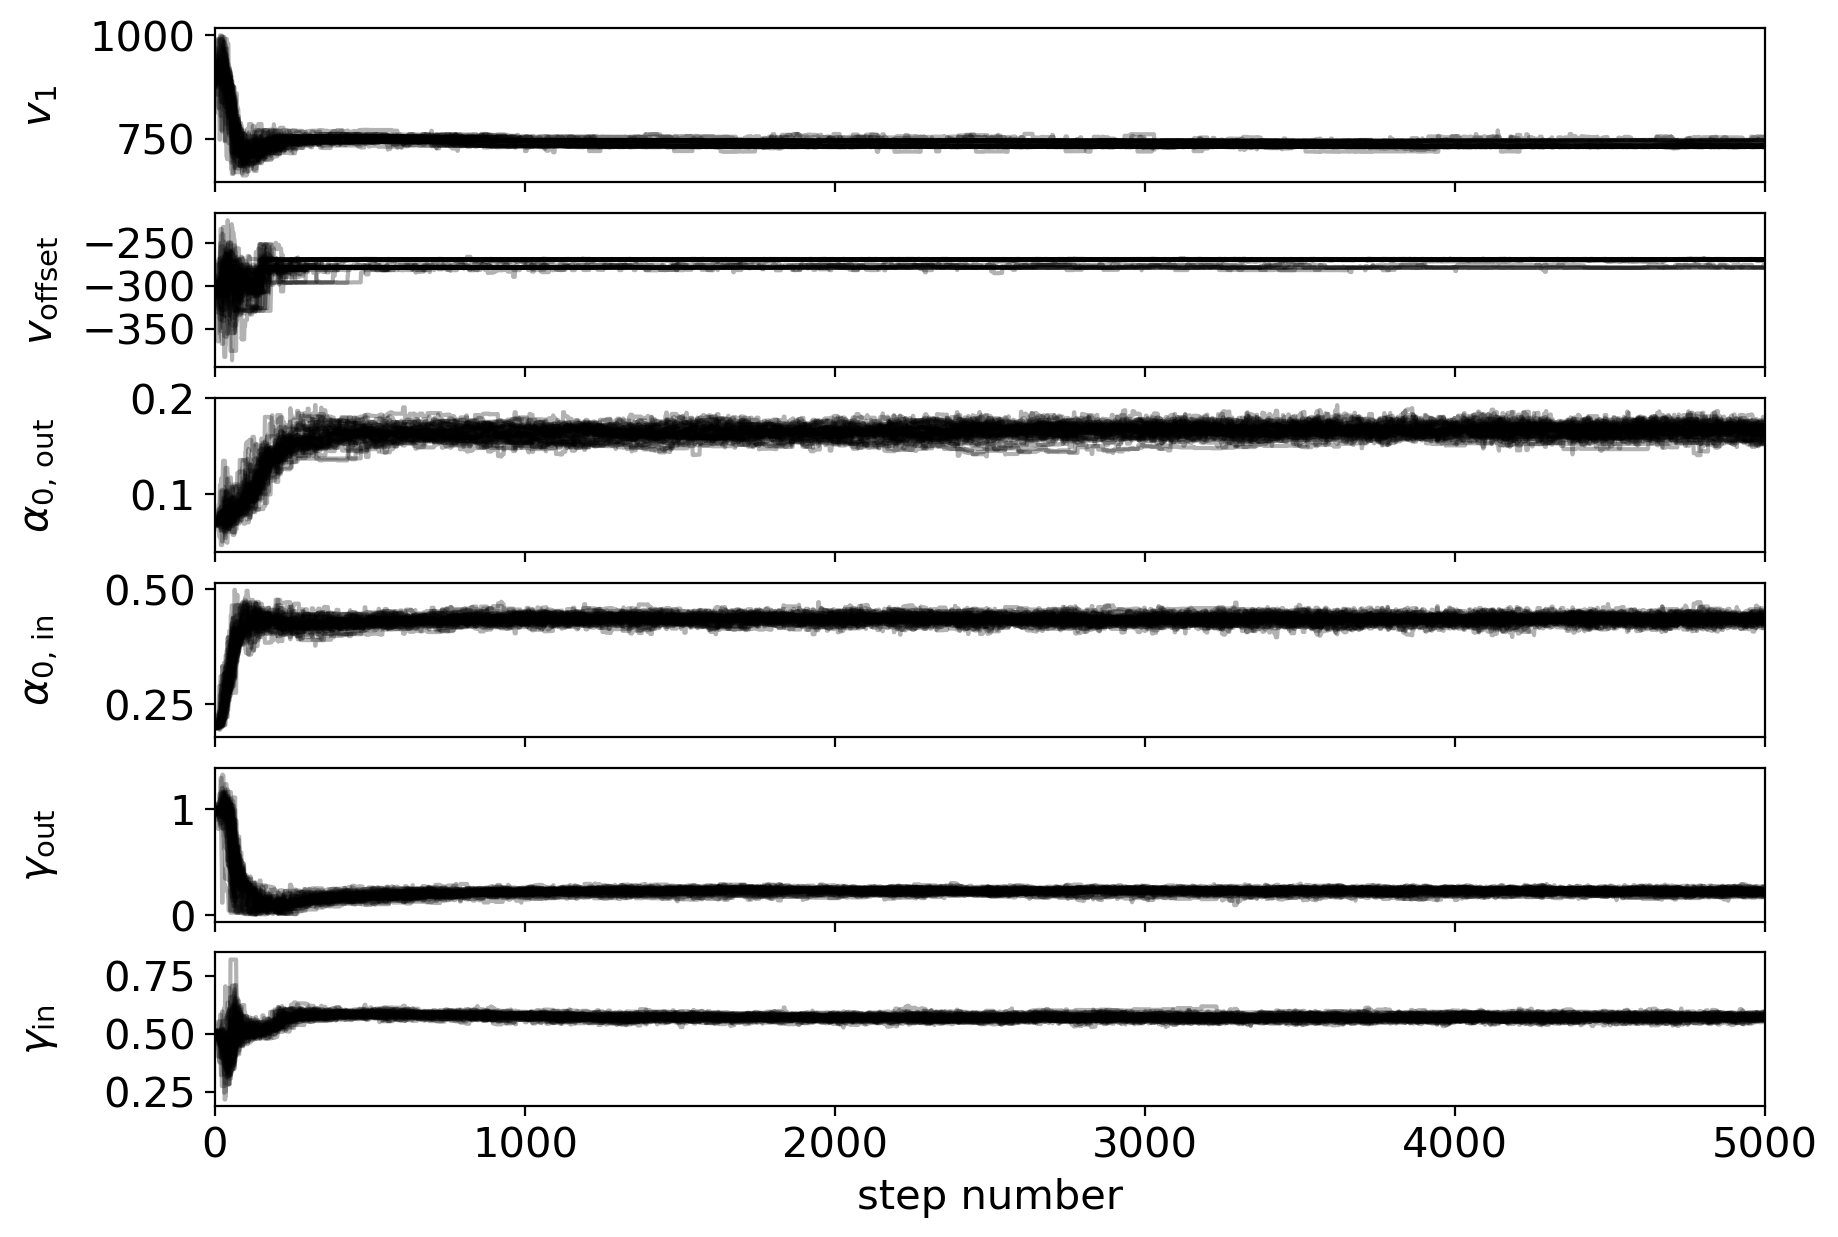

In [12]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
labels_tex = ["$v_1$", "$v_\mathrm{offset}$", "$\\alpha_\mathrm{0,\,out}$", "$\\alpha_\mathrm{0,\,in}$", "$\\gamma_\mathrm{out}$", "$\\gamma_\mathrm{in}$"]
labels = ['vmax', 'voffset', 'alpha_out', 'alpha_in', 'gout', 'gin']
# labels = ["vmin", "alpha_in", "gin"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_tex[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
tau = reader.get_autocorr_time(quiet=True)
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
# samples = reader.get_chain(flat=True)

N/50 = 100;
tau: [205.5897963  321.08870518 269.98646589 128.59523563  58.26772453
 130.99389976]


[205.5897963  321.08870518 269.98646589 128.59523563  58.26772453
 130.99389976]


733.90372959761
740.5831392468141
732.6640682482977


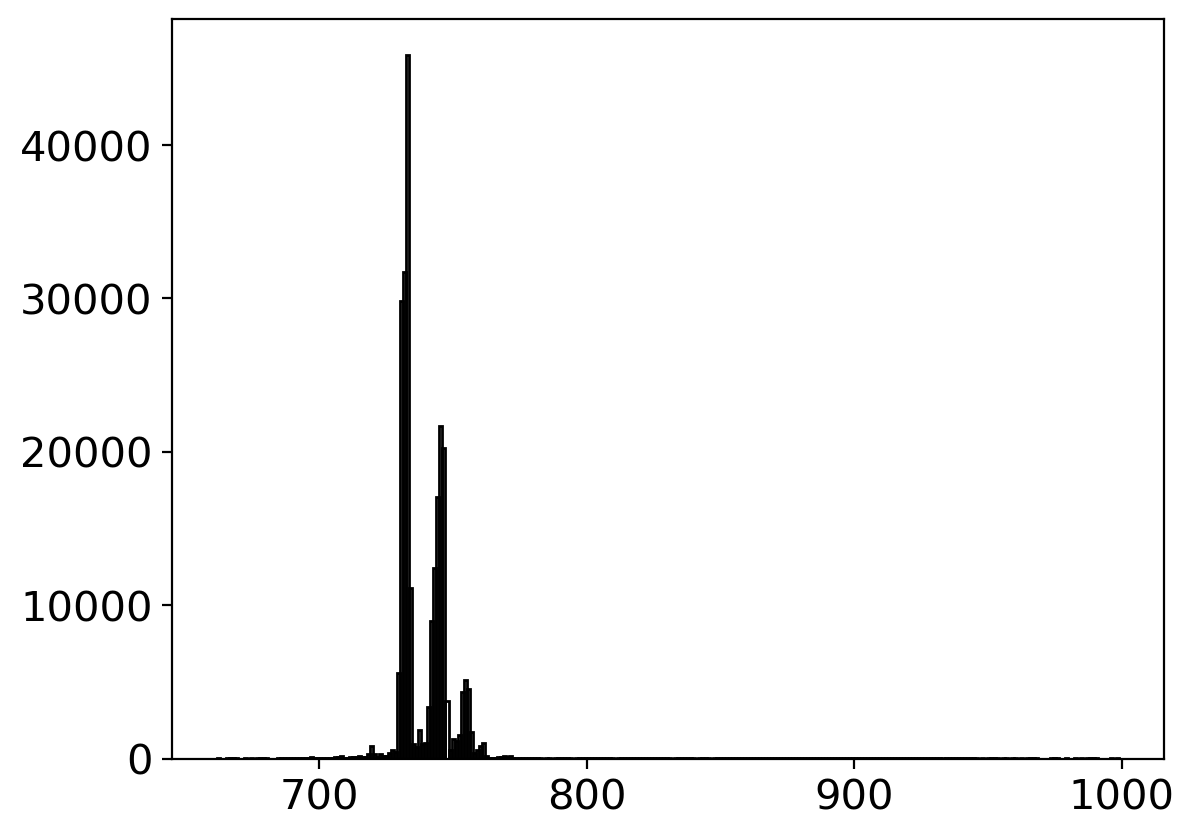

In [9]:
flat_samples = reader.get_chain(flat=True) # discard=100, thin=15, flat=True
print(np.median(flat_samples[:,0]))
print(np.mean(flat_samples[:,0]))

hi = plt.hist(flat_samples[:,0], fill=None, bins=300)
print(hi[1][np.argmax(hi[0])])
plt.show()


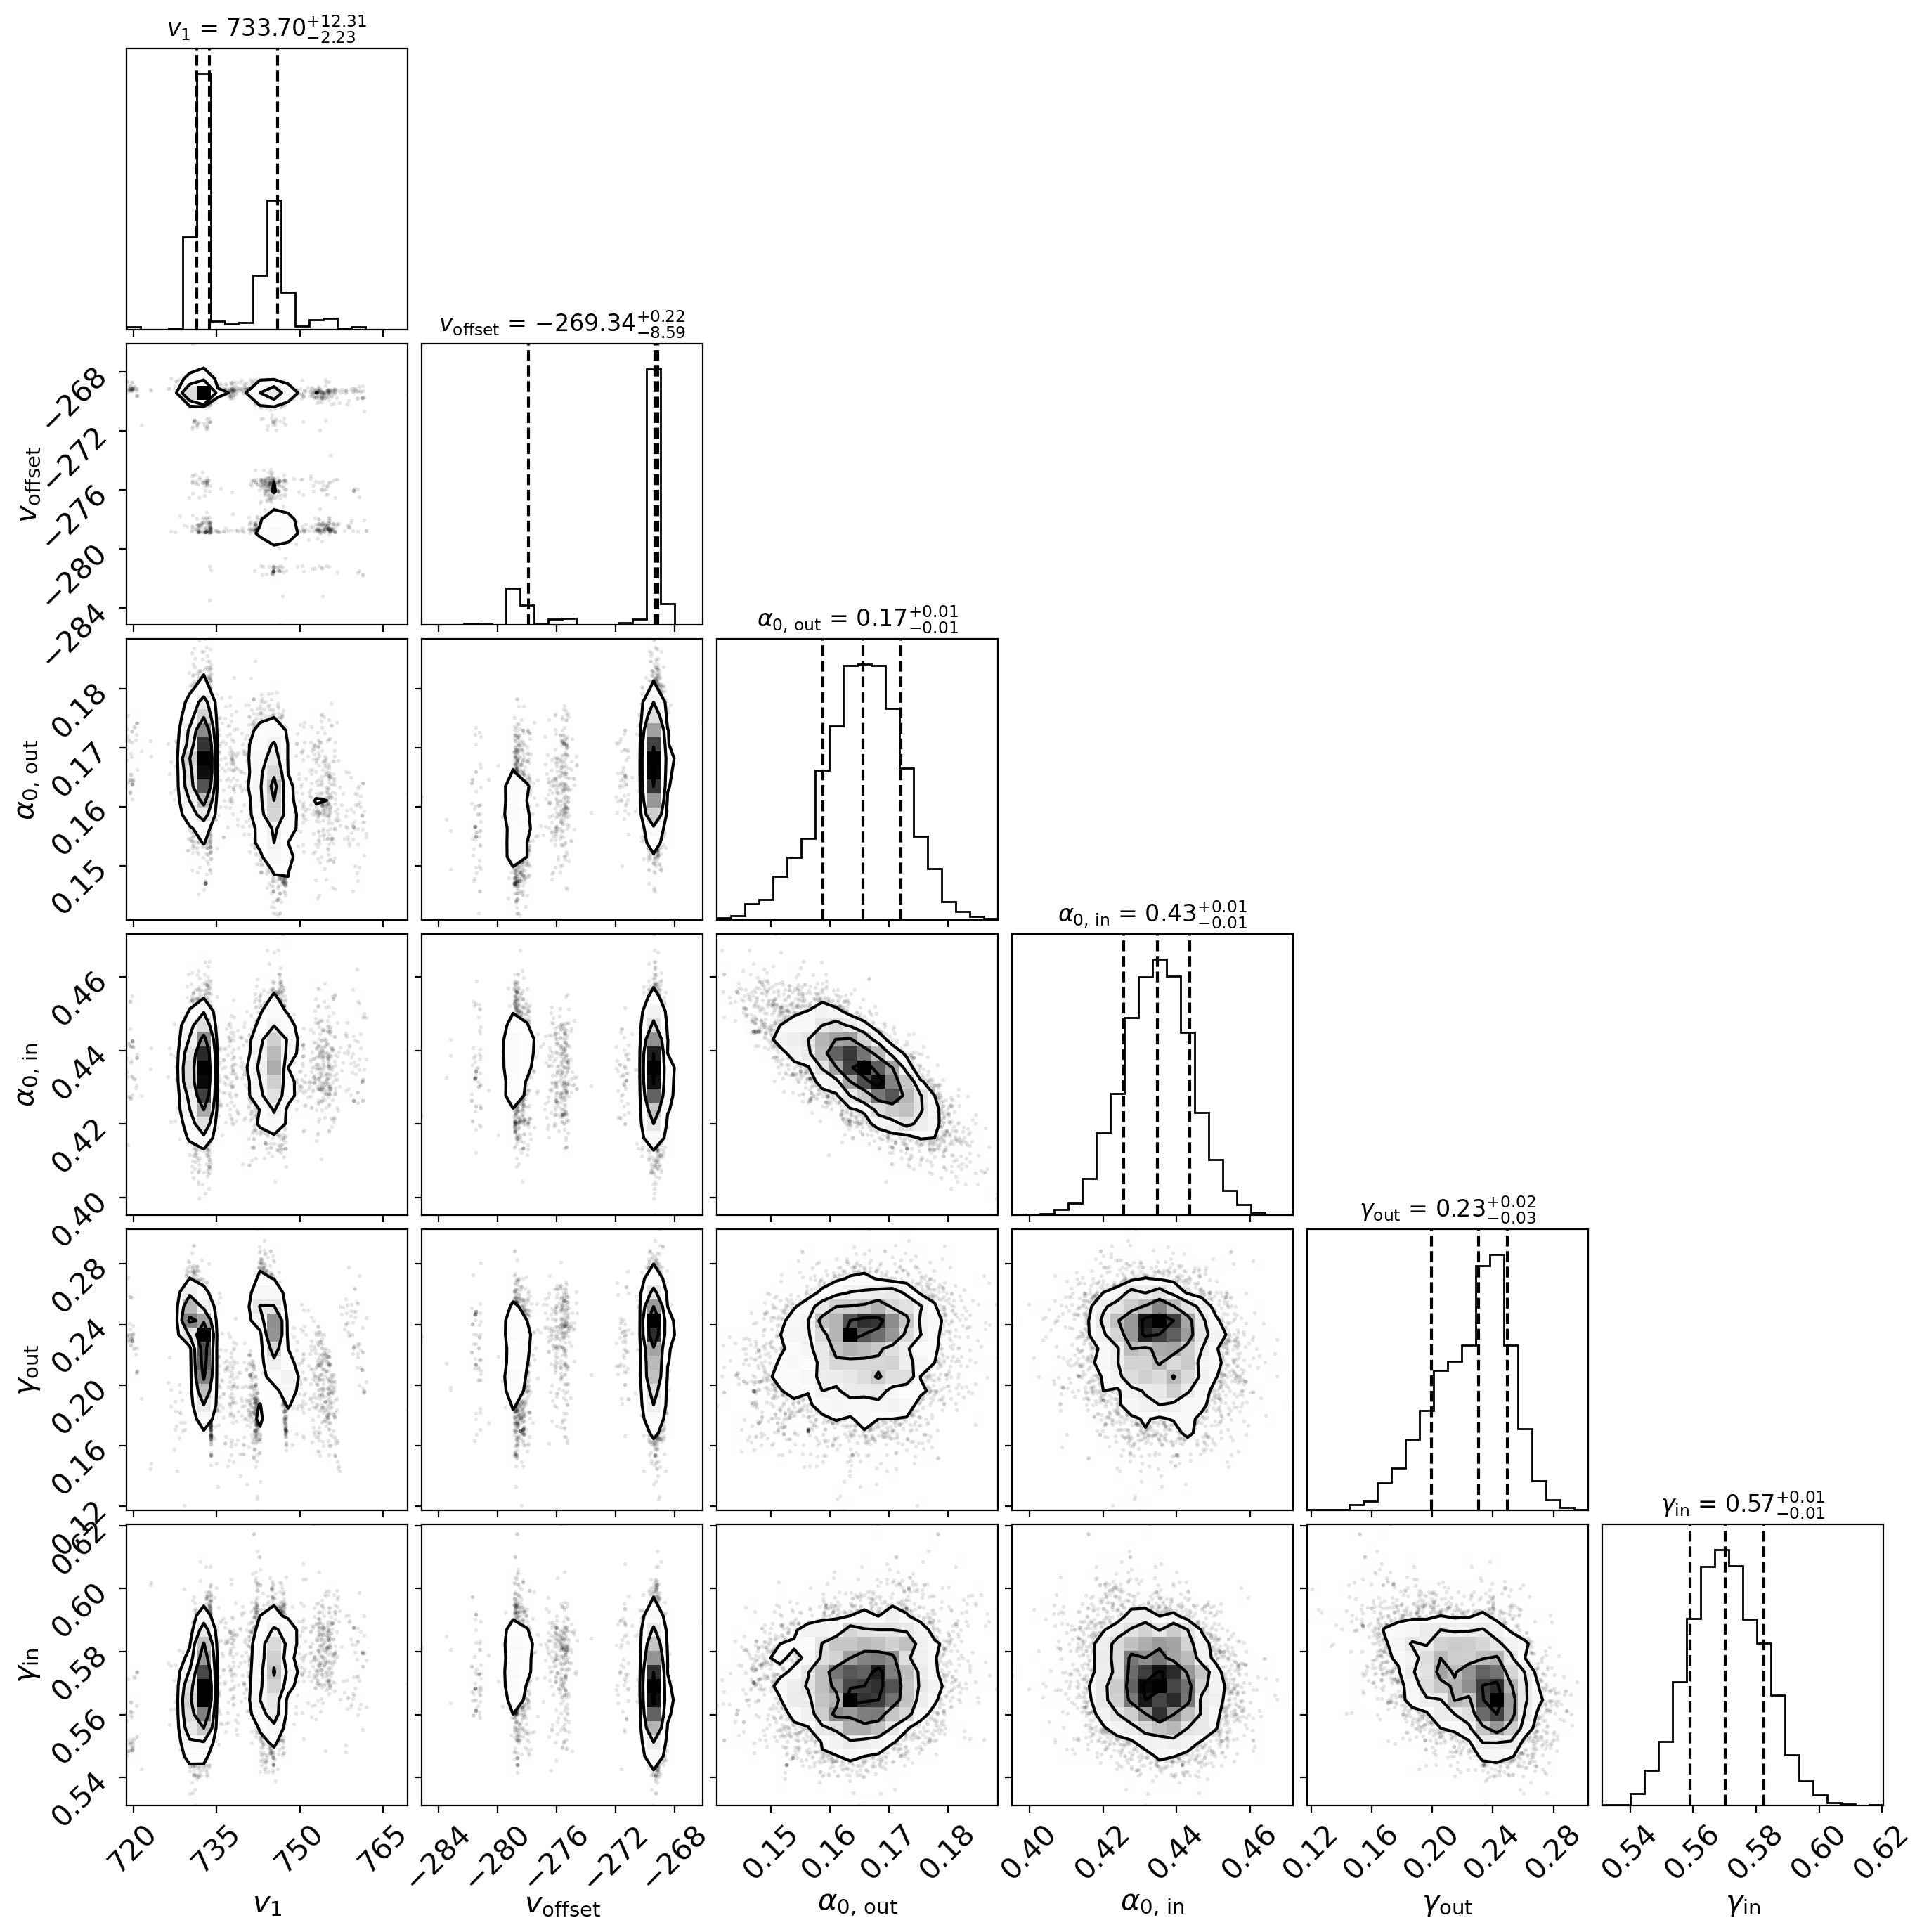

In [14]:
fig = corner.corner(
    samples, labels=labels_tex, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, #truths=initial
);
plt.savefig('out+in_corner_240728.pdf')

In [15]:
# Out to Table

In [16]:
# filename = "tutorial_25w_1500it.h5" #"tutorial_10w_1500it.h5"
inout_fn = "MCMC_outputs/trimmed_50w_5000it.h5" #"tutorial_10w_1500it.h5"
inout_samp = emcee.backends.HDFBackend(inout_fn).get_chain(flat=True)

out_fn = "MCMC_outputs/trimmed_outonly_20w_1500it.h5"
out_samp = emcee.backends.HDFBackend(out_fn).get_chain(flat=True)


In [25]:
labels_samp_inout = {"$v_1$ (km s$^{-1}$)":0, "$v_\mathrm{offset}$ (km s$^{-1}$)":1, "$\\alpha_\mathrm{0,\,out}$":2, "$\\alpha_\mathrm{0,\,in}$":3, "$\\gamma_\mathrm{out}$":4, "$\\gamma_\mathrm{in}$":5}
labels_samp_out = {"$v_1$ (km s$^{-1}$)":0, "$\\alpha_\mathrm{0,\,out}$":1, "$\\gamma_\mathrm{out}$":2}
labels_tab = ["$v_1$ (km s$^{-1}$)", "$\\alpha_\mathrm{0,\,out}$", "$\\gamma_\mathrm{out}$", "$v_\mathrm{offset}$ (km s$^{-1}$)", "$\\alpha_\mathrm{0,\,in}$", "$\\gamma_\mathrm{in}$"] 
for li, l in enumerate(labels_tab):
    # print(l)
    ind_inout = labels_samp_inout[l]
    med_inout = np.median(inout_samp[:,ind_inout])
    lb_inout = np.quantile(inout_samp[:,ind_inout],0.16) - med_inout
    ub_inout = np.quantile(inout_samp[:,ind_inout],0.84) - med_inout
    
    if li < 3:
        #outflow components, need both datasets
        ind_out = labels_samp_out[l]
        med_out = np.median(out_samp[:,ind_out])
        lb_out = np.quantile(out_samp[:,ind_out],0.16) - med_out
        ub_out = np.quantile(out_samp[:,ind_out],0.84) - med_out
        if l == '$v_1$ (km s$^{-1}$)':
            print(f'Outflow & {l} & ${med_inout:.2f}\,^{{+{ub_inout:.2f}}}_{{{lb_inout:.2f}}}$ & ${med_out:.2f}\,^{{+{ub_out:.2f}}}_{{{lb_out:.2f}}}$ \\\\')
        else:
            print(f"& {l} & ${med_inout:.2f}\,^{{+{ub_inout:.2f}}}_{{{lb_inout:.2f}}}$ & ${med_out:.2f}\,^{{+{ub_out:.2f}}}_{{{lb_out:.2f}}}$ \\\\")
    else:
        # inflow components
        if l == "$v_\mathrm{offset}$ (km s$^{-1}$)":
            print(f'Inflow & {l} & ${med_inout:.2f}\,^{{+{ub_inout:.2f}}}_{{{lb_inout:.2f}}}$ & . \\nodata \\\\')
        else:
            print(f"& {l} & ${med_inout:.2f}\,^{{+{ub_inout:.2f}}}_{{{lb_inout:.2f}}}$ & . \\nodata \\\\")

Outflow & $v_1$ (km s$^{-1}$) & $733.90\,^{+12.82}_{-2.40}$ & $660.57\,^{+4.40}_{-0.11}$ \\
& $\alpha_\mathrm{0,\,out}$ & $0.16\,^{+0.01}_{-0.01}$ & $0.40\,^{+0.01}_{-0.01}$ \\
& $\gamma_\mathrm{out}$ & $0.23\,^{+0.02}_{-0.04}$ & $0.35\,^{+0.00}_{-0.06}$ \\
Inflow & $v_\mathrm{offset}$ (km s$^{-1}$) & $-269.37\,^{+0.24}_{-9.12}$ & . \nodata \\
& $\alpha_\mathrm{0,\,in}$ & $0.43\,^{+0.01}_{-0.01}$ & . \nodata \\
& $\gamma_\mathrm{in}$ & $0.57\,^{+0.01}_{-0.01}$ & . \nodata \\


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\,'
<>:18: SyntaxWarning: invalid escape sequence '\,'
<>:20: SyntaxWarning: invalid escape sequence '\,'
<>:20: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\,'
<>:26: SyntaxWarning: invalid escape sequence '\,'
<>:1: SyntaxWarning: invalid escape sequenc

In [45]:
labels_tab

{'$v_1$': 0,
 '$v_\\mathrm{offset}$': 1,
 '$\\alpha_\\mathrm{0,\\,out}$': 2,
 '$\\alpha_\\mathrm{0,\\,in}$': 3,
 '$\\gamma_\\mathrm{out}$': 4,
 '$\\gamma_\\mathrm{in}$': 5}

In [77]:
# filename = "tutorial_25w_1500it.h5" #"tutorial_10w_1500it.h5"
filename = "MCMC_outputs/trimmed_outonly_20w_1500it.h5" #"tutorial_10w_1500it.h5"
# nwalkers = 10
# niter = 500
# initial = np.array([603, 0.3, 0.17])
ndims = 3 #6 #len(initial)
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(flat=True)
# print(samples[0,:,:])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

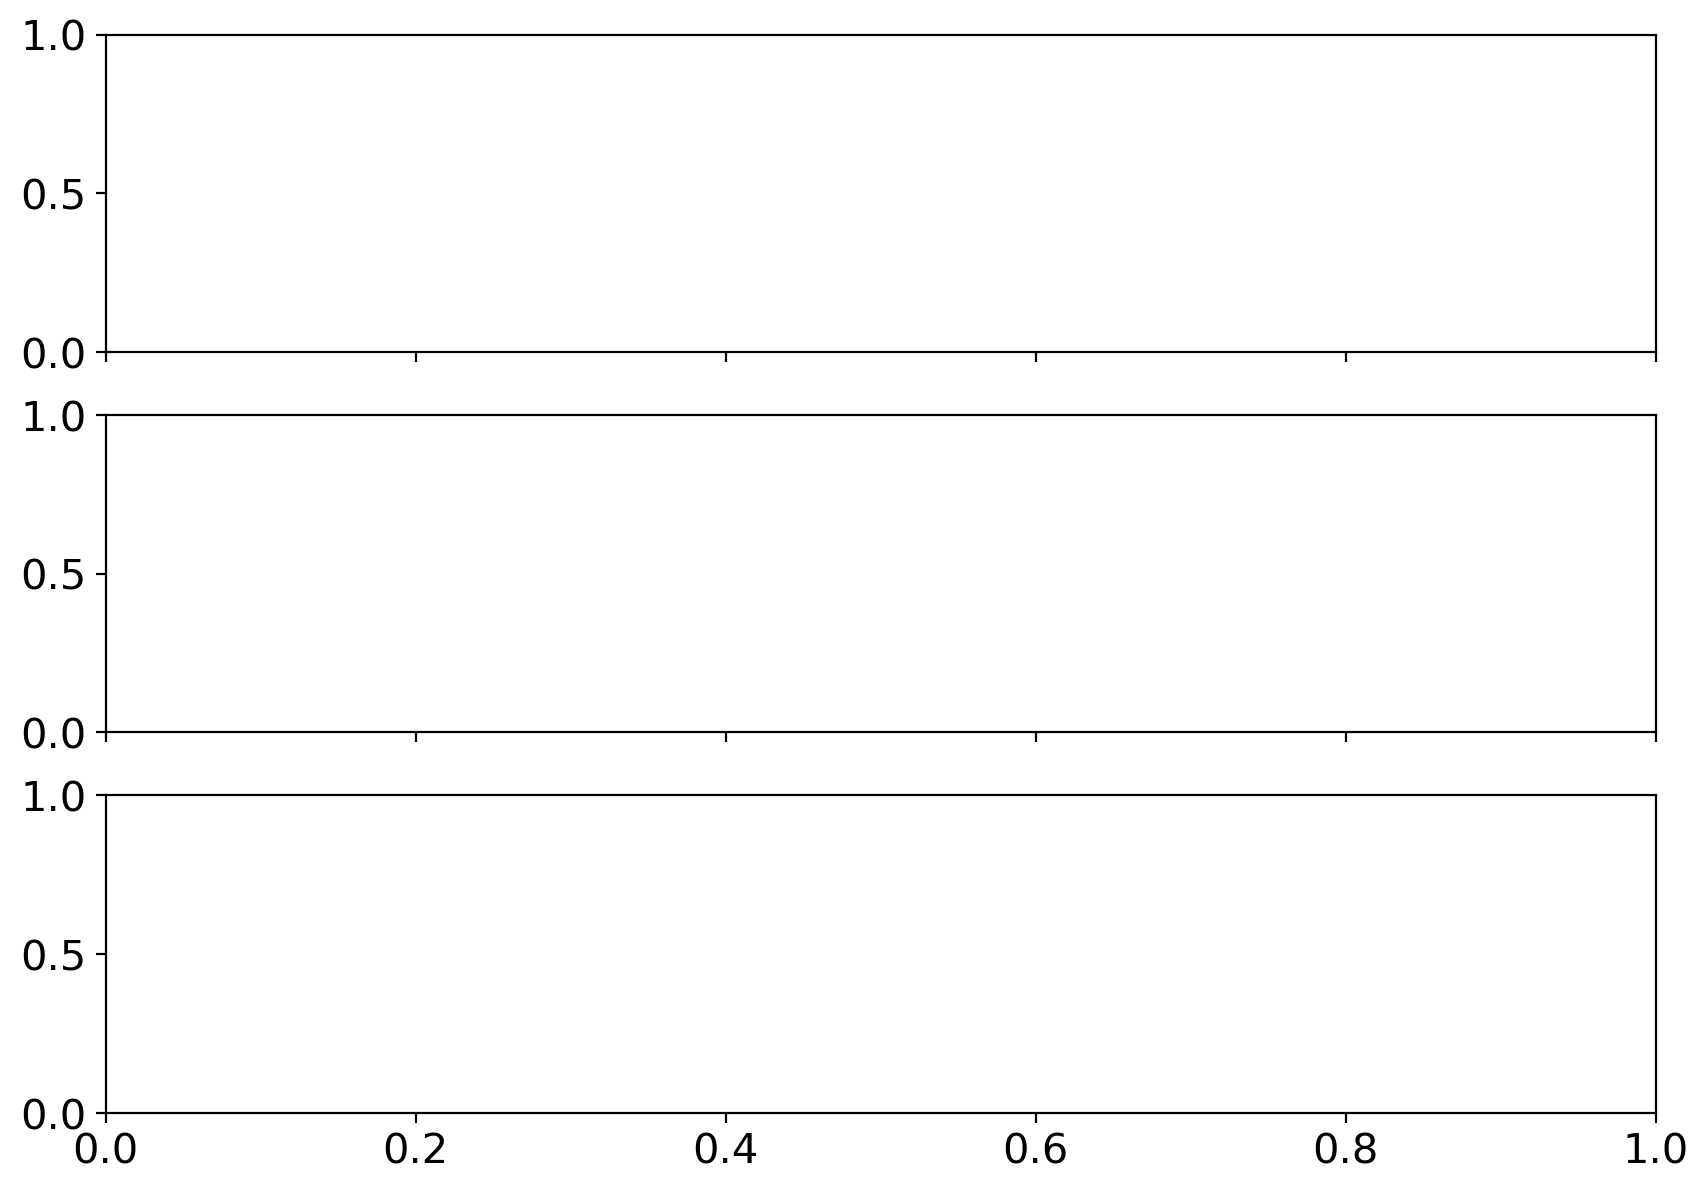

In [78]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ["vmax", "vmin", "alpha_out", "alpha_in", "gout", "gin"]
labels = ["vmax", "alpha_out", "gout"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

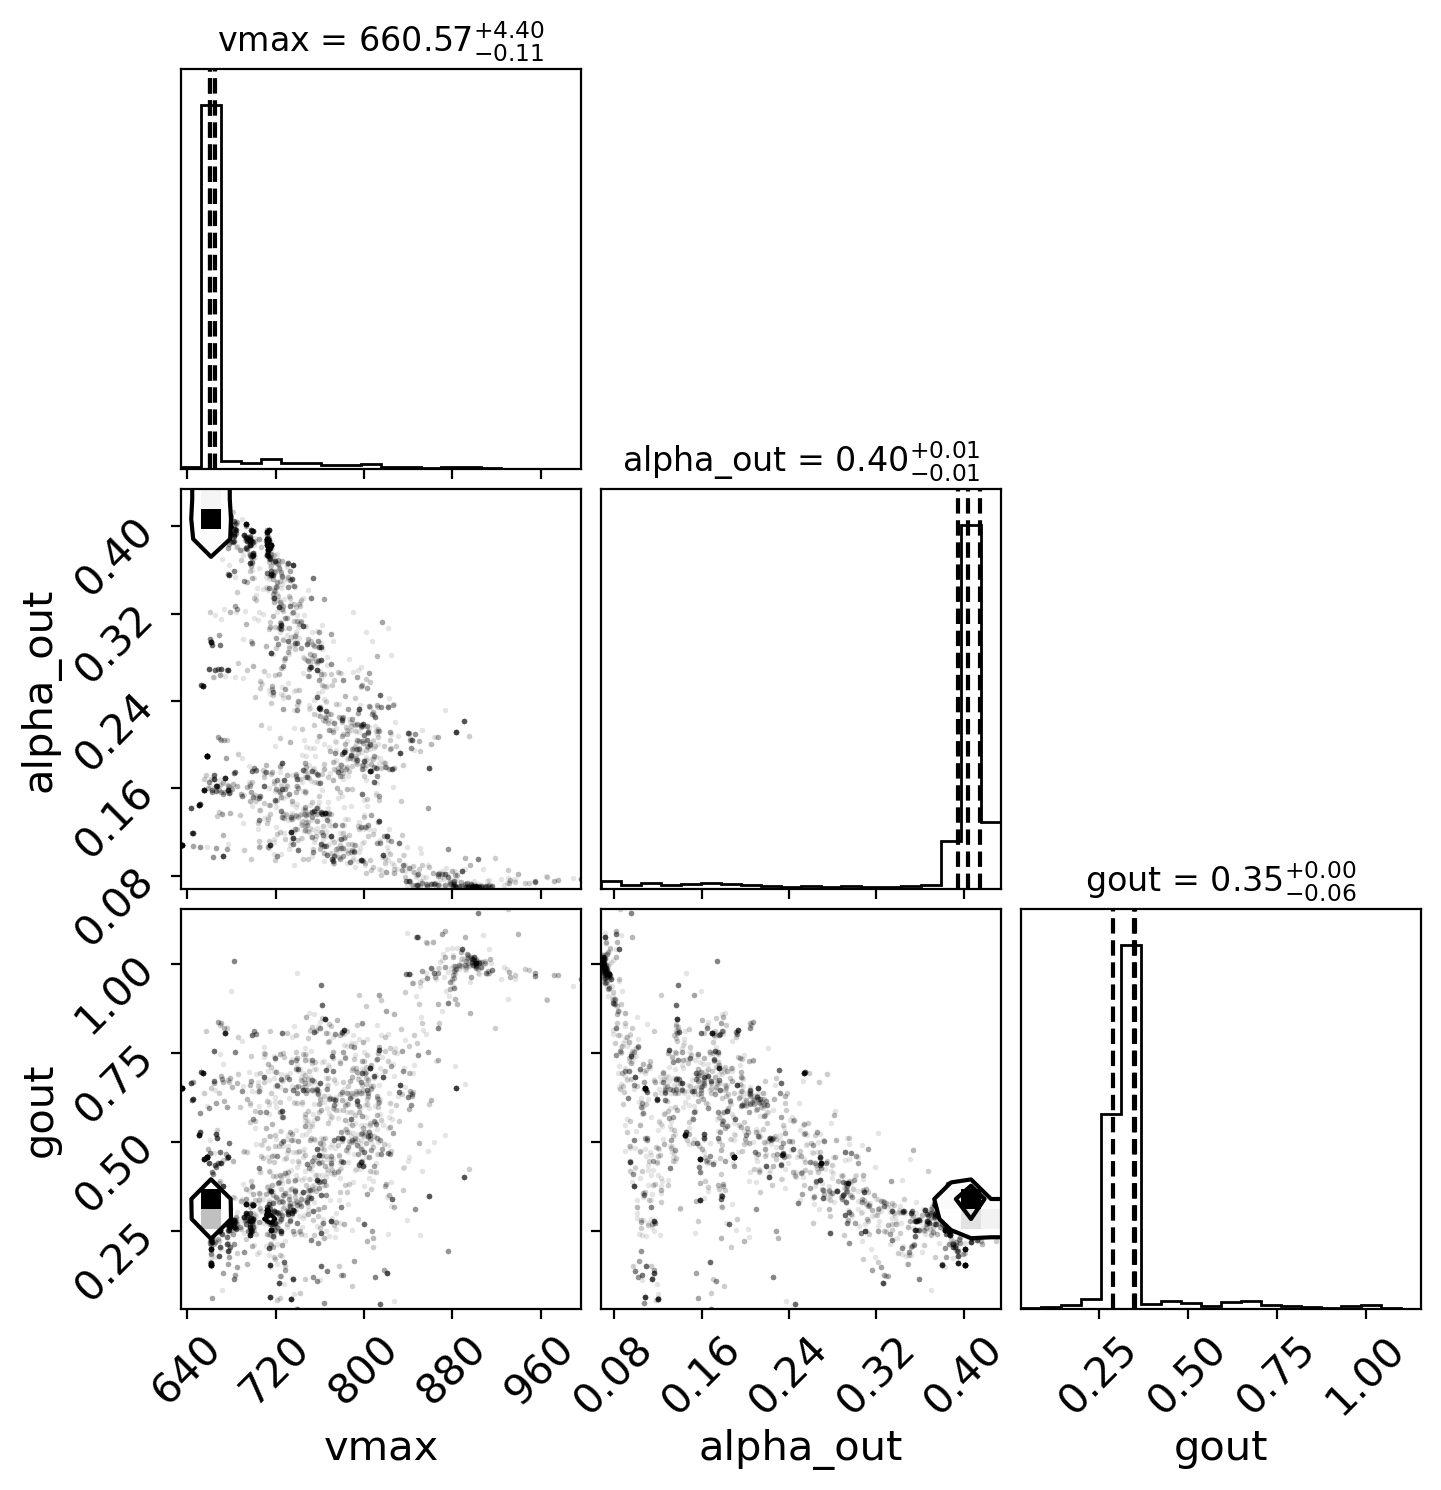

In [79]:
fig = corner.corner(
    samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, #truths=initial
);

In [12]:
thtest = (603, 0.3, 0.17)
lnlike(thtest)

/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


-7.174882546368743

/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


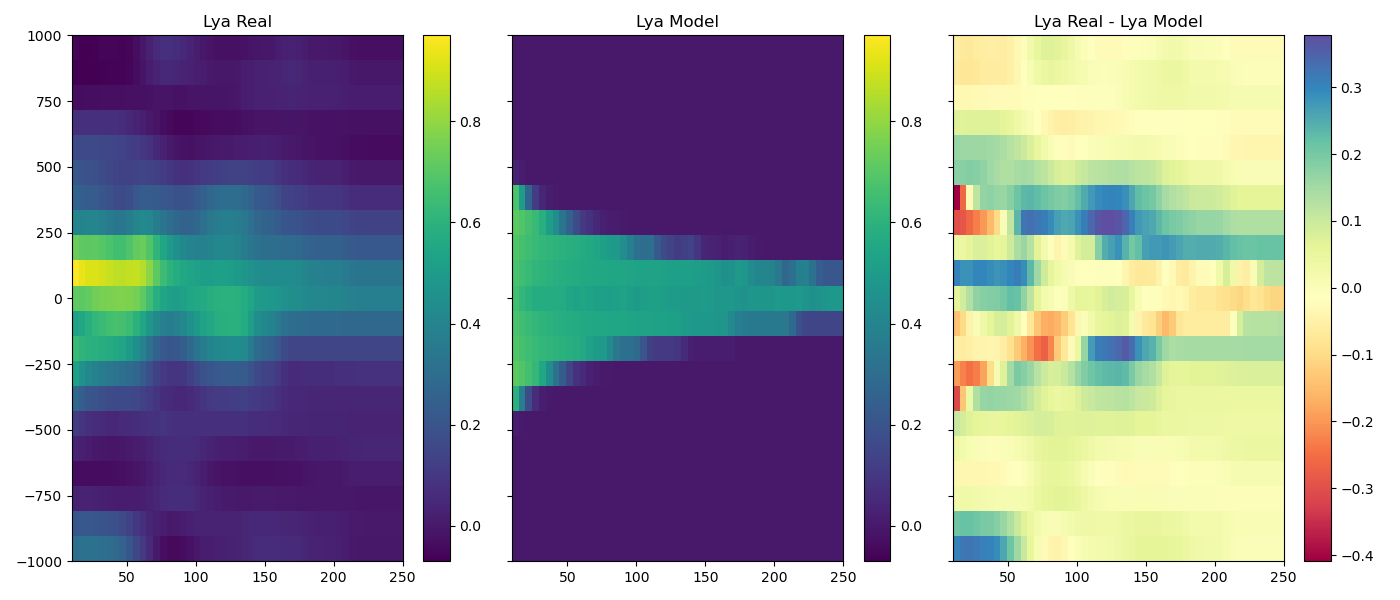

In [11]:
thtest = (603, 0.3, 0.17) #vout, vin, aout, ain, gout, gin
lya_model = model(thtest) 

vmi, vma = -0.07, 0.97

fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='Spectral')
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()